# LULC classification with Machine Learning (ML)

Traning data collection from GEE

In [1]:
import geemap
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AdQt8qjdWGKIyznyJViw-WVRNTsBkWN4PZ79PPCu7hgT_dl7TcRVH8AL3hs



Successfully saved authorization token.


### Adding asset from GEE

In [14]:
geemap.ee_search()

In [15]:
aoi = ee.FeatureCollection('users/Animesh_Choudhury/Ahmedabad_Gandhinagar')

In [4]:
Map = geemap.Map(center=[25, 88], zoom=4)
#Map

In [5]:
Map.addLayer(aoi)
#Map

### converting GEE code to python

In [15]:
js_snippet = """
// Define a function that scales and masks Landsat 8 surface reflectance images.
function prepSrL8(image) {
  // Develop masks for unwanted pixels (fill, cloud, cloud shadow).
  var qaMask = image.select('QA_PIXEL').bitwiseAnd(parseInt('11111', 2)).eq(0);
  var saturationMask = image.select('QA_RADSAT').eq(0);

  // Apply the scaling factors to the appropriate bands.
  var getFactorImg = function(factorNames) {
    var factorList = image.toDictionary().select(factorNames).values();
    return ee.Image.constant(factorList);
  };
  var scaleImg = getFactorImg([
    'REFLECTANCE_MULT_BAND_.|TEMPERATURE_MULT_BAND_ST_B10']);
  var offsetImg = getFactorImg([
    'REFLECTANCE_ADD_BAND_.|TEMPERATURE_ADD_BAND_ST_B10']);
  var scaled = image.select('SR_B.|ST_B10').multiply(scaleImg).add(offsetImg);

  // Replace original bands with scaled bands and apply masks.
  return image.addBands(scaled, null, true)
    .updateMask(qaMask).updateMask(saturationMask);
}


"""

In [16]:
geemap.js_snippet_to_py(
    js_snippet, add_new_cell=True, import_ee=True, import_geemap=True, show_map=True
)

In [16]:
# Define a function that scales and masks Landsat 8 surface reflectance images.
def prepSrL8(image):
  # Develop masks for unwanted pixels (fill, cloud, cloud shadow).
  qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0) 
  saturationMask = image.select('QA_RADSAT').eq(0)

  # Apply the scaling factors to the appropriate bands.
  def getFactorImg(factorNames):
    factorList = image.toDictionary().select(factorNames).values()
    return ee.Image.constant(factorList)
  
  scaleImg = getFactorImg([
    'REFLECTANCE_MULT_BAND_.|TEMPERATURE_MULT_BAND_ST_B10'])
  offsetImg = getFactorImg([
    'REFLECTANCE_ADD_BAND_.|TEMPERATURE_ADD_BAND_ST_B10'])
  scaled = image.select('SR_B.|ST_B10').multiply(scaleImg).add(offsetImg)

  # Replace original bands with scaled bands and apply masks.
  return image.addBands(scaled, None, True) \
    .updateMask(qaMask).updateMask(saturationMask)

In [17]:
L8_SR = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(aoi)
    .filterDate('2020-01-01', '2020-12-31')
    .map(prepSrL8)
    .select('SR_B[1-7]')
    .median()
    .clip(aoi)
    
)

vis_params = {'min': 0, 'max': 1, 'bands': ['SR_B4', 'SR_B3', 'SR_B2']}

Map.centerObject(aoi, 4)
Map.addLayer(L8_SR, vis_params, "Landsat-8")
#Map

In [18]:
#image.getInfo()

### Computation of Remote Sensing Indices

### Bands 
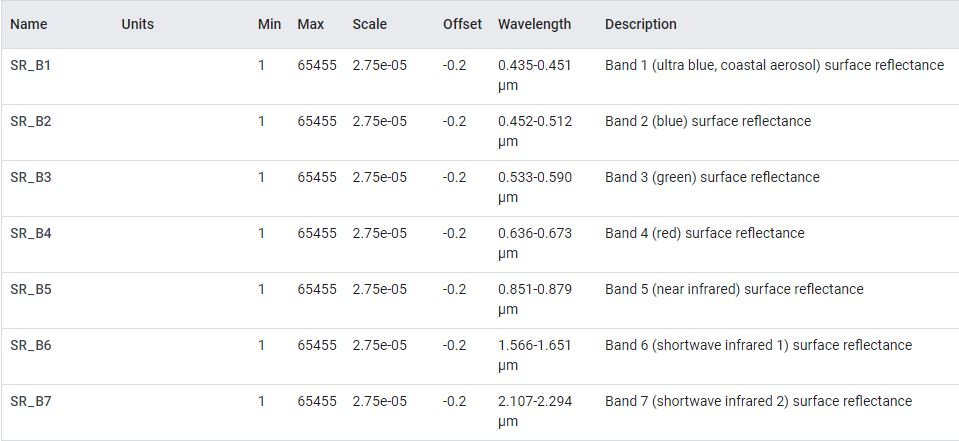

In [19]:
# https://github.com/awesome-spectral-indices/awesome-spectral-indices
# https://awesome-ee-spectral-indices.readthedocs.io/en/latest/list.html#
def addIndex(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    ndwi = image.normalizedDifference(['SR_B3', 'SR_B5']).rename('NDWI')
    ndbi = image.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')
    ndsi = image.normalizedDifference(['SR_B3', 'SR_B6']).rename('NDSI')
    return image.addBands(ndvi).addBands(ndwi).addBands(ndbi).addBands(ndsi)



In [20]:
L8_SR = addIndex(L8_SR)

In [21]:
L8_SR.getInfo()

{'type': 'Image',
 'bands': [{'id': 'SR_B1',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B2',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B3',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B4',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B5',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -0.2,
    'max': 1.6022125},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'SR_B6',
   'data_type': {'ty

In [22]:
ESA_lulc = ee.ImageCollection('ESA/WorldCover/v100').first().select('Map')

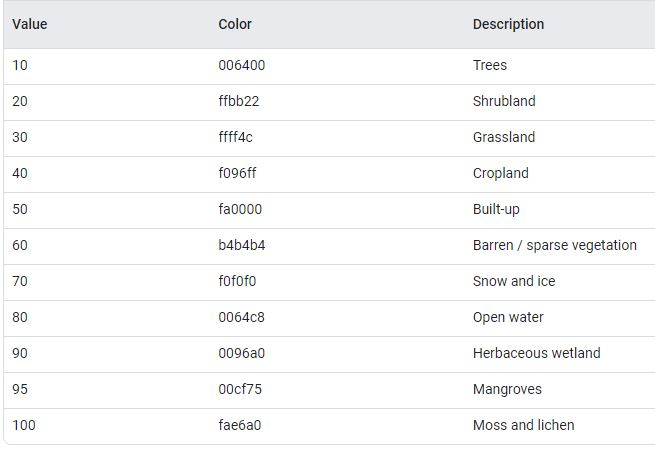

In [25]:
# Sample the input imagery to get a FeatureCollection of training data.
training = L8_SR.addBands(ESA_lulc).stratifiedSample(
    **{
  'region': aoi,
  'classBand': 'Map',
  'scale': 30,
  'numPoints': 5000,
  'geometries': True,
  'seed': 0,
        })

Map.addLayer(training, {}, 'training', False)

In [26]:
print(training.size().getInfo())

35176


In [54]:
print(training.first().getInfo())

{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [72.7307944215751, 23.25320553978326]}, 'id': '0', 'properties': {'Map': 10, 'NDVI': 0.5571601986885071, 'SR_B1': 0.030450000000000005, 'SR_B2': 0.042082499999999995, 'SR_B3': 0.07343250000000001, 'SR_B4': 0.07895999999999997, 'SR_B5': 0.2776475, 'SR_B6': 0.21095999999999998, 'SR_B7': 0.14287}}


In [55]:
type(training)

ee.featurecollection.FeatureCollection

In [65]:
feature_list = training.toList(3676)
#print(training.select(0).getInfo())

In [71]:
type(feature_list.get(0).getInfo())

dict

In [78]:
feature_list.get(0).getInfo().get('properties').get('Map')

10

### Export an ee.FeatureCollection to Local Computer

In [27]:
import os
out_dir = os.path.expanduser("E:/Earth_Engine")

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [28]:
Map.addLayer(training, {}, "data_points")
Map.centerObject(training)
Map

Map(center=[23.08673573643569, 72.55937593062299], controls=(WidgetControl(options=['position', 'transparent_b…

In [29]:
out_shp = os.path.join(out_dir, "data_points.csv")
geemap.ee_export_vector(training, out_shp, verbose=True)

Generating URL ...
Please wait ...
Data downloaded to E:\Earth_Engine\data_points.csv


# Data Preparation 

In [1]:
import pandas as pd

In [2]:
input_features = pd.read_csv("E:/Earth_Engine/data_points.csv" )
input_features.head()
                             

,SR_B2,NDSI,SR_B3,SR_B4,SR_B5,SR_B6,NDWI,SR_B7,NDVI,SR_B1,NDBI,Map,system:index
0,0.039497,-0.470410,0.070572,0.067987,0.290160,0.195945,-0.608727,0.123675,0.620338,0.029378,-0.193816,10,0
1,0.035015,-0.492637,0.066819,0.074780,0.258975,0.196577,-0.589809,0.110461,0.551887,0.024235,-0.136971,10,1
2,0.044420,-0.424231,0.078080,0.077750,0.270278,0.193140,-0.551725,0.132502,0.553196,0.033145,-0.166454,10,2
3,0.037242,-0.472656,0.070875,0.069472,0.291095,0.197925,-0.608393,0.125875,0.614649,0.027232,-0.190524,10,3
4,0.038178,-0.516952,0.068263,0.069197,0.266840,0.214370,-0.592587,0.135747,0.588156,0.027287,-0.109038,10,4


In [3]:
input_features = input_features.drop(columns='system:index', axis = 1)

In [4]:
input_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35176 entries, 0 to 35175
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SR_B2   35176 non-null  float64
 1   NDSI    35176 non-null  float64
 2   SR_B3   35176 non-null  float64
 3   SR_B4   35176 non-null  float64
 4   SR_B5   35176 non-null  float64
 5   SR_B6   35176 non-null  float64
 6   NDWI    35176 non-null  float64
 7   SR_B7   35176 non-null  float64
 8   NDVI    35176 non-null  float64
 9   SR_B1   35176 non-null  float64
 10  NDBI    35176 non-null  float64
 11  Map     35176 non-null  int64  
dtypes: float64(11), int64(1)
memory usage: 3.2 MB


In [5]:
input_features = input_features[input_features['Map'] != 90]
input_features.head()

,SR_B2,NDSI,SR_B3,SR_B4,SR_B5,SR_B6,NDWI,SR_B7,NDVI,SR_B1,NDBI,Map
0,0.039497,-0.470410,0.070572,0.067987,0.290160,0.195945,-0.608727,0.123675,0.620338,0.029378,-0.193816,10
1,0.035015,-0.492637,0.066819,0.074780,0.258975,0.196577,-0.589809,0.110461,0.551887,0.024235,-0.136971,10
2,0.044420,-0.424231,0.078080,0.077750,0.270278,0.193140,-0.551725,0.132502,0.553196,0.033145,-0.166454,10
3,0.037242,-0.472656,0.070875,0.069472,0.291095,0.197925,-0.608393,0.125875,0.614649,0.027232,-0.190524,10
4,0.038178,-0.516952,0.068263,0.069197,0.266840,0.214370,-0.592587,0.135747,0.588156,0.027287,-0.109038,10


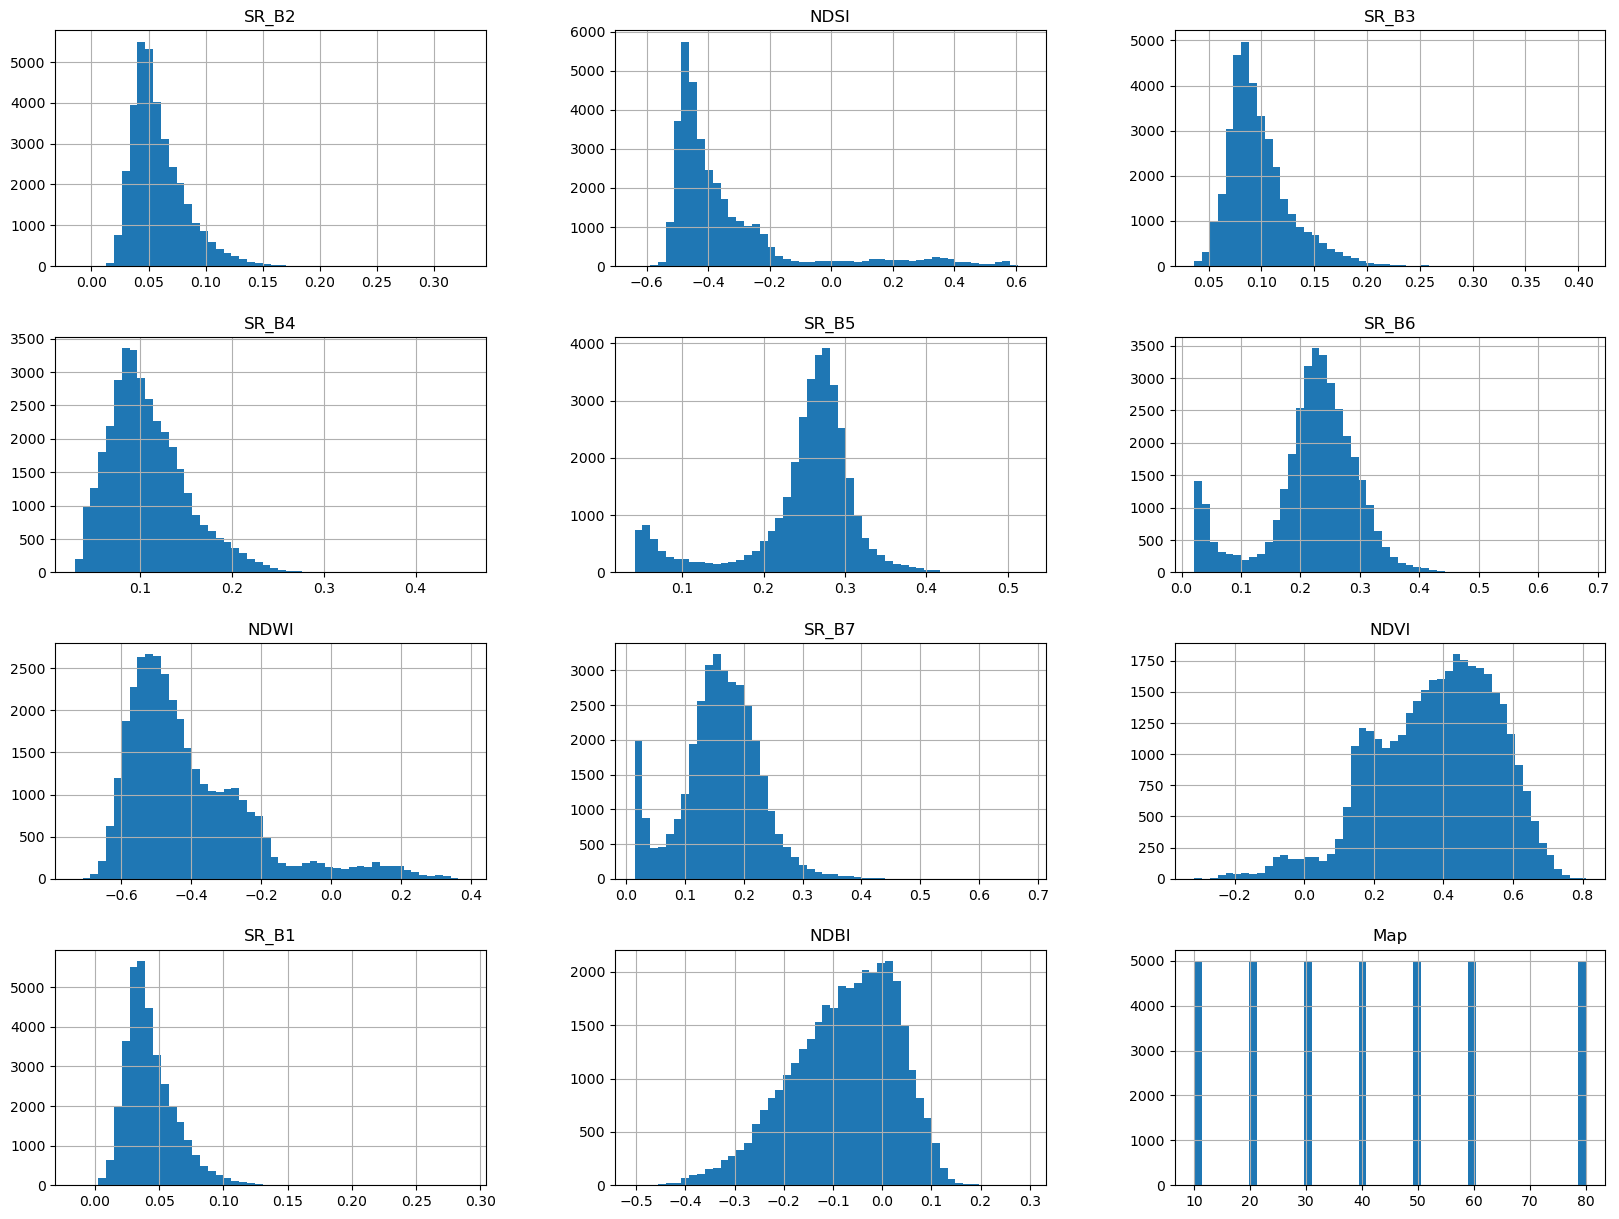

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
input_features.hist(bins=50, figsize=(20,15))

plt.show()

In [7]:
input_features['Map'].unique()

array([10, 20, 30, 40, 50, 60, 80], dtype=int64)

In [8]:
input_features = input_features.replace({10: 0, 20: 1, 30: 1, 40: 2, 50: 3, 60: 1, 80: 4, })

In [9]:
input_features['Map'].value_counts()

1    15000
0     5000
2     5000
3     5000
4     5000
Name: Map, dtype: int64

### ML Architechture

In [10]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
X = input_features.drop(['Map'], axis=1)
y = input_features['Map']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [11]:
# machine learing model pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [12]:
model_pipeline = []
model_pipeline.append(LogisticRegression(solver = 'liblinear'))
model_pipeline.append(SVC())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GaussianNB())

In [13]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
 
model_list = [ 'Logistic Regression', 'SVM', 'KNN', 'Decision Tree', 'Random Forest', 'Naive Bayes']
acc_list = []
auc_list = []
cm_list = []

for model in model_pipeline:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc_list.append(metrics.accuracy_score(y_test, y_pred))
    #fpr, tpr, _thresolds = metrics.roc_curve(y_test, y_pred)
    #auc_list.append(round(metrics.auc(fpr, tpr),2))
    cm_list.append(confusion_matrix(y_test, y_pred))

In [14]:
# libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

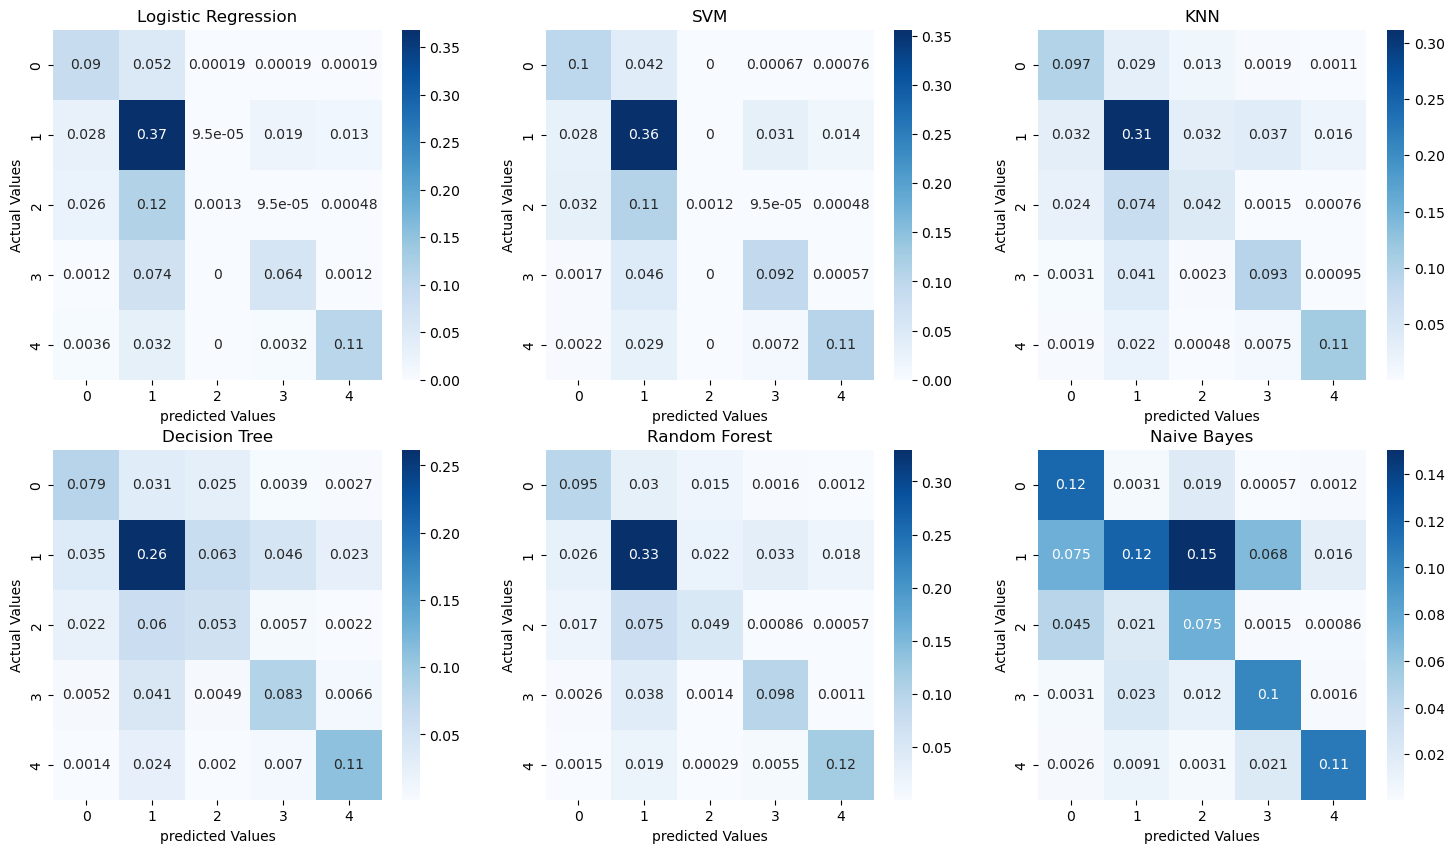

In [15]:
# plot  confusion matrix

fig = plt.figure(figsize= (18,10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(2, 3, i+1).set_title(model)
    #cm_plot = plt.imshow( cm , cmap = 'cool' , interpolation = 'nearest')
    cm_plot =  sns.heatmap(cm/np.sum(cm), annot = True, cmap = 'Blues')
    cm_plot.set_xlabel('predicted Values')
    cm_plot.set_ylabel('Actual Values')

In [17]:
result_df = pd.DataFrame({'Model' : model_list, 'Accuracy': acc_list})
result_df

,Model,Accuracy
0,Logistic Regression,0.629619
1,SVM,0.655238
2,KNN,0.656476
3,Decision Tree,0.586952
4,Random Forest,0.690286
5,Naive Bayes,0.523048


In [25]:
# K-fold cross-validation
from sklearn.model_selection import cross_val_score
model = RandomForestClassifier()
scores = cross_val_score(model, X_train, y_train, cv=10)
#tree_rmse_scores = np.sqrt(-scores)

In [26]:
print("scores:", scores)
print("Mean:", scores.mean())
print("Standard deviation:", scores.std())

scores: [0.66938776 0.67673469 0.67673469 0.68530612 0.68734694 0.68122449
 0.67959184 0.67918367 0.66897959 0.67632653]
Mean: 0.6780816326530613
Standard deviation: 0.005626290402221436


### Calculation of Feature Importance
https://machinelearningmastery.com/calculate-feature-importance-with-python/

Feature: 0, Score: 14.68143
Feature: 1, Score: 21.87111
Feature: 2, Score: -22.79883
Feature: 3, Score: 24.72346
Feature: 4, Score: 14.01197
Feature: 5, Score: -21.56212
Feature: 6, Score: -12.68271
Feature: 7, Score: 5.52686
Feature: 8, Score: 5.56062
Feature: 9, Score: -23.32588
Feature: 10, Score: 24.75845


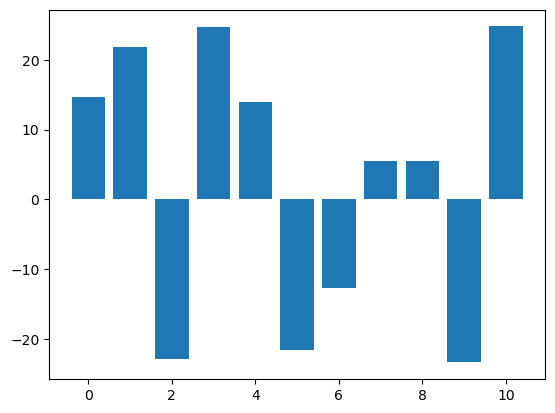

In [18]:
# linear regression feature importance
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
# define dataset
#X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = LinearRegression()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Feature: 0, Score: 0.04117
Feature: 1, Score: 0.13538
Feature: 2, Score: 0.04071
Feature: 3, Score: 0.06301
Feature: 4, Score: 0.06666
Feature: 5, Score: 0.05116
Feature: 6, Score: 0.35324
Feature: 7, Score: 0.05902
Feature: 8, Score: 0.09163
Feature: 9, Score: 0.05295
Feature: 10, Score: 0.04507


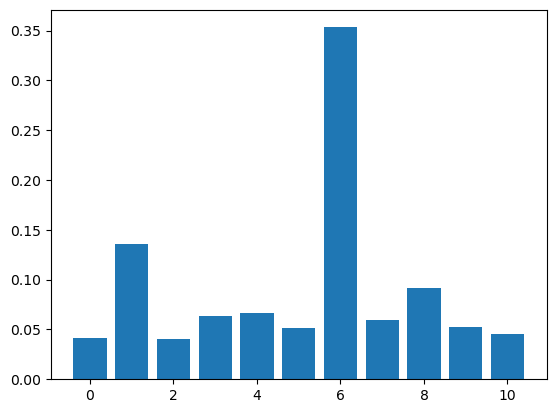

In [21]:
# random forest for feature importance on a regression problem
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
# define dataset
#X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = RandomForestRegressor()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [20]:
# xgboost for feature importance on a regression problem
from sklearn.datasets import make_regression
from xgboost import XGBRegressor
from matplotlib import pyplot
# define dataset
#X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = XGBRegressor()
# fit the model
model.fit(X_train, y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

ModuleNotFoundError: No module named 'xgboost'

Feature: 0, Score: 0.04099
Feature: 1, Score: 0.89205
Feature: 2, Score: 0.02478
Feature: 3, Score: 0.08843
Feature: 4, Score: 0.21510
Feature: 5, Score: 0.23249
Feature: 6, Score: 0.74758
Feature: 7, Score: 0.31134
Feature: 8, Score: 0.55674
Feature: 9, Score: 0.04360
Feature: 10, Score: 0.25354


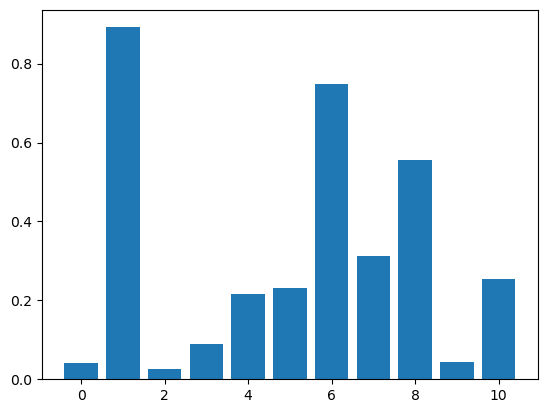

In [22]:
# permutation feature importance with knn for regression
#from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
# define dataset
#X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
# define the model
model = KNeighborsClassifier()
# fit the model
model.fit(X_train, y_train)
# perform permutation importance
results = permutation_importance(model, X, y, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

### Hyperparameter Tuning to improve Accuracy

In [30]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [31]:
# Create the param grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [32]:
from sklearn.model_selection import RandomizedSearchCV
model = RandomForestClassifier()
rf_RandomGrid = RandomizedSearchCV(estimator = model, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 4)

In [33]:
rf_RandomGrid.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 4],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [10, 17, 25, 33, 41, 48,
                                                         56, 64, 72, 80]},
                   verbose=2)

In [35]:
rf_RandomGrid.best_params_

{'n_estimators': 64,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 4,
 'bootstrap': True}

In [36]:
print (f'Train Accuracy - : {rf_RandomGrid.score(X_train,y_train):.3f}')
print (f'Test Accuracy - : {rf_RandomGrid.score(X_test,y_test):.3f}')

Train Accuracy - : 0.647
Test Accuracy - : 0.647


In [18]:
# https://www.analyticsvidhya.com/blog/2021/01/gaussian-naive-bayes-with-hyperpameter-tuning/
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

In [19]:
model=RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [23]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import PowerTransformer
# params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=model, 
#                      param_grid=params_NB, 
#                      cv=cv_method,
#                      verbose=1, 
#                      scoring='accuracy')

# Data_transformed = PowerTransformer().fit_transform(X_test)

# gs_NB.fit(Data_transformed, y_test);

In [22]:
model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])